In [1]:
import numpy as np
import torch
import pandas as pd

import matplotlib.pyplot as plt

from collections import namedtuple
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import data_processing as dp
import model
import model_utilities as util
import vocab
import batch_samplers

In [3]:
import os

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

In [5]:
import importlib

In [6]:
importlib.reload(model)

<module 'model' from '/data/itasarom/diplom/gan_embeddings/GAN/model.py'>

In [7]:
def normalize_embeddings(embeddings):
    EPS = 1e-9
    mean = embeddings[1:].mean(axis=0, keepdims=True)
    se = (embeddings[1:].var(axis=0, keepdims=True)  + EPS )**0.5
#     embeddings
    embeddings = (embeddings - mean)/se
    embeddings[0, :] = 0
    return embeddings

In [8]:
vocab1, all_labels, sents1, labels1 = dp.load_problem(lang='fr', max_sent_length=100)
# vocab2, all_labels, sents2, labels2 = dp.load_problem(lang='es', max_sent_length=100)
# vocab1, all_labels, sents1, labels1 = dp.load_problem(lang='ru')
vocab2, all_labels, sents2, labels2 = dp.load_problem(lang='en', max_sent_length=100)

In [9]:
# vocab1.embeddings.var(axis=0)

In [10]:
vocab1.embeddings = normalize_embeddings(vocab1.embeddings)
vocab2.embeddings = normalize_embeddings(vocab2.embeddings)

In [11]:
# vocab1.embeddings.var(axis=0)

In [12]:
len(vocab1.embeddings), len(vocab2.embeddings)

(47377, 47404)

In [13]:
len(sents1), len(sents2)

(18641, 17860)

In [14]:
torch.cuda.is_available()

True

In [15]:
sent_sampler_1 = batch_samplers.BatchSamplerRegularizer(sents=sents1, labels=labels1, vocab=vocab1, all_labels=all_labels, max_sent_length=None, seed=42)

In [16]:
sent_sampler_2 = batch_samplers.BatchSamplerRegularizer(sents=sents2, labels=labels2, vocab=vocab2, all_labels=all_labels, max_sent_length=None, seed=42)

In [17]:
print(len(sent_sampler_1.sents), len(sent_sampler_2.sents))

18641 17860


In [18]:
embed_sampler_1 = batch_samplers.BatchSamplerDiscriminator(vocab1)

In [19]:
embed_sampler_2 = batch_samplers.BatchSamplerDiscriminator(vocab2)

In [20]:
import IPython


In [24]:
sent_sampler_1.test[0][111]

['le',
 'ministère',
 'du',
 'travail',
 'de',
 'l',
 'emploi',
 'et',
 'de',
 'la',
 'sécurité',
 'sociale',
 'a',
 'annoncé',
 'hier',
 'dans',
 'un',
 'communiqué',
 'que',
 'la',
 'journée',
 'de',
 'mardi',
 '1er',
 'novembre',
 '2016',
 'sera',
 '<pad>',
 'et',
 'payée',
 'ce',
 'congé',
 'chômé',
 'et',
 'payé',
 'concerne',
 'l',
 'ensemble',
 'des',
 'personnels',
 'des',
 'institutions',
 'et',
 'administrations',
 'publiques',
 'des',
 'services',
 'spécialisés',
 'des',
 'collectivités',
 'locales',
 'et',
 'les',
 'entreprises',
 'commerciales',
 'industrielles',
 'artisanales',
 'et',
 'agricoles',
 'y',
 'compris',
 'les',
 'personnels',
 'payés',
 'à',
 'l',
 'heure',
 'et',
 'à',
 'la',
 'journée',
 'toutefois',
 'les',
 'personnes',
 'exerçant',
 'en',
 'travail',
 'posté',
 'sont',
 'tenues',
 'd',
 'assurer',
 'la',
 'continuité',
 'du',
 'service',
 'selon',
 'le',
 'règlement',
 'fixé',
 'par',
 'l',
 'employeur']

In [25]:
sent_sampler_2.test[0][111]

['4',
 'colourlovers',
 'viewed',
 'this',
 'page',
 'and',
 'think',
 '<pad>',
 'is',
 'better',
 'than',
 'chocolate',
 'rank',
 'description',
 'bitch',
 'ok',
 'i',
 '<pad>',
 'u',
 'just',
 'called',
 'me',
 'cute',
 'like',
 '20',
 'minutes',
 'ago',
 'but',
 'im',
 '<pad>',
 'u',
 'right',
 'now',
 'boy',
 'u',
 'are',
 'straight',
 'as',
 'fuck',
 'and',
 'u',
 'will',
 'never',
 'have',
 '2',
 'go',
 'through',
 'the',
 'shame',
 'and',
 'terror',
 'and',
 'discomfort',
 'i',
 'have',
 'and',
 'u',
 'will',
 'never',
 'have',
 'to',
 'wonder',
 'if',
 'ur',
 'just',
 'as',
 'real',
 'as',
 'anybody',
 'else',
 'or',
 'why',
 'it',
 'was',
 'u',
 'and',
 'not',
 'the',
 'others',
 'u',
 'wont',
 'so',
 'don',
 't',
 'tell',
 'me',
 'u',
 'think',
 'u',
 'can']

In [26]:
cls = model.GAN(100, len(all_labels))

In [27]:
torch.cuda.current_device()

0

In [28]:
cls = cls.cuda()

In [29]:
# params = {
#     'save_path': "./model_checkpoint.tc",
#     'save_every':10,
#     'sentence_iterations':200,
#     'discr_iterations':1,
#     'transform_iterations':500,
#     'n_sents_1':128,
#     'n_sents_2':128,
#     'n_discr_1':128,
#     'n_discr_2':128,
#     'n_iter':20
    
# }

# params = {
#     'save_path': "./model_checkpoint.tc",
#     'save_every':10,
#     'sentence_iterations':2,
#     'discr_iterations':1,
#     'transform_iterations':5,
#     'n_sents_1':128,
#     'n_sents_2':128,
#     'n_discr_1':128,
#     'n_discr_2':128,
#     'n_iter':20
    
# }

# params = {
#     'save_path': "./model_checkpoint_2_layers.tc",
#     'save_every':10,
#     'sentence_iterations':200,
#     'discr_iterations':10,
#     'transform_iterations':20,
#     'n_sents_1':128,
#     'n_sents_2':128,
#     'n_discr_1':1024,
#     'n_discr_2':1024,
#     'n_iter':100
    
# }


params = {
    'save_path': "./model_checkpoint_sentences_fr_en_dropout_2.tc",
    'save_every':10,
    'sentence_iterations':50,
    'discr_iterations':10,
    'transform_iterations':25,
    'n_sents_1':256,
    'n_sents_2':256,
    'n_discr_1':1024,
    'n_discr_2':1024,
    'n_iter':100,
    'validate_every':1
    
}

In [30]:
# trainer.global_iterations = 60

In [31]:
trainer = util.Trainer(cls)

In [32]:
# trainer.restore("./model_checkpoint_sentences_fr_en_dropout_2.tc")
# # cls.train()

In [33]:
# torch.abs(cls.transformation_1.bias - cls.transformation_2.bias).max()[0
# sents1[0]

In [34]:
# vocab1.embeddings[40]
# [k for k in vocab1.transformation if vocab1.transformation[k] == 40 ]

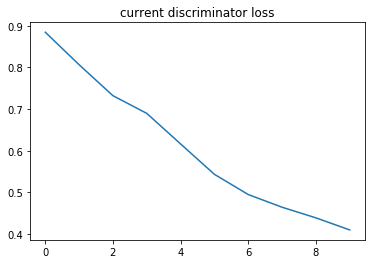

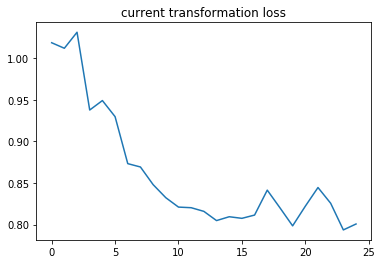

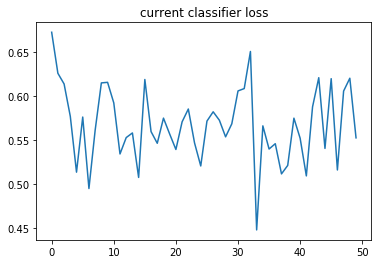

Iter 99 class 0.5674207210540771, discr0.6082699298858643, transform 0.8615179657936096


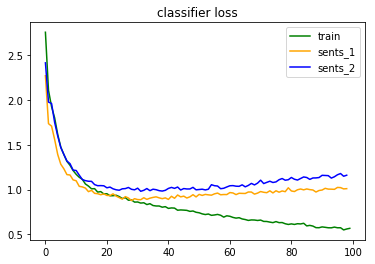

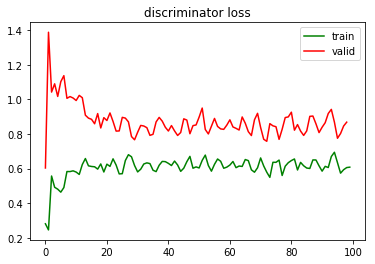

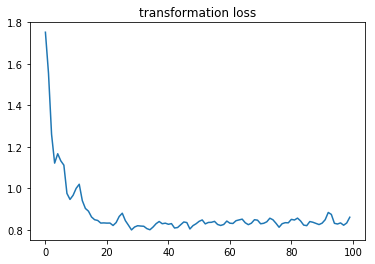

after epoch_id


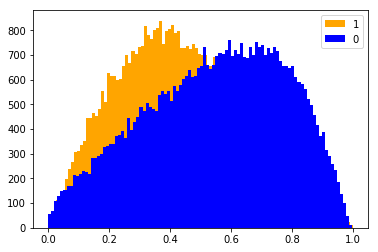

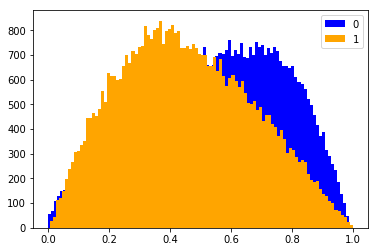

Embedding accuracy  0.40349859148985556
Embedding loss  0.9503093950498915
Confusion matrix
 [[19155. 28222.]
 [28315. 19089.]]
Min component variance 0.28330734372138977, median component variance 0.4287448525428772, mean component variance 0.4394680857658386, max c v 0.6798434853553772
Sents1 (761, 1024, 0.7431640625) [1.0275363]
Sents2 (707, 1024, 0.6904296875) [1.2206998]


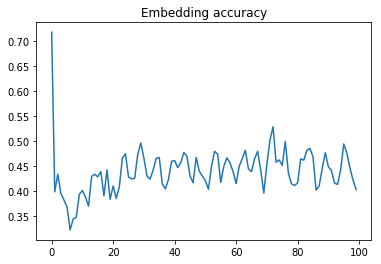

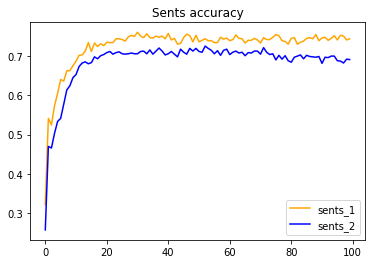

In [35]:
# trainer.t
trainer.train(sent_sampler_1, sent_sampler_2, embed_sampler_1, embed_sampler_2, params)

In [36]:
import sklearn
from sklearn.metrics import log_loss, accuracy_score

In [37]:
def build_confusion_matrix(predicted_probs, true_y):
    n_labels = predicted_probs.shape[1]
#     assert true_y.shape == predicted_probs.shape
    result = np.zeros(shape=(n_labels, n_labels))
    
    pred = predicted_probs.argmax(axis=1)
#     true = true_y.argmax(axis=1)
    true = true_y
    
    for pred_cls in range(n_labels):
        for true_cls in range(n_labels):
            result[true_cls, pred_cls] = np.count_nonzero(true[pred == pred_cls] == true_cls)
#     norm = result.sum(axis=1)
#     norm = np.maximum(norm, 1)
#     result /= norm[:, None]
    return result


In [38]:
def get_probs(transformation, model, embeddings, batch_size, use_cuda):
    result = []
#     embed_sum = 0.0
#     squares_sum = 0.0
    embeds = []
    for position in range(0, len(embeddings), batch_size):
        x = embeddings[position:position + batch_size]
        x = torch.autograd.Variable(torch.from_numpy(x)).float()
        if use_cuda:
            x = x.cuda()
        
        x = transformation(x)
        _, probs = model.discriminator.forward(x)
        probs = probs.data.cpu().numpy()
        result.append(probs)
        
        x = x.cpu().data.numpy()
#         embed_sum += x
        embeds.append(x)
    
    result = np.vstack(result)
    z = 1 - result
    result = np.hstack([z, result])
    return result, np.vstack(embeds)

In [39]:
def build_confusion_matrix(predicted_probs, true_y):
    n_labels = predicted_probs.shape[1]
#     assert true_y.shape == predicted_probs.shape
    result = np.zeros(shape=(n_labels, n_labels))
    
    pred = predicted_probs.argmax(axis=1)
#     true = true_y.argmax(axis=1)
    true = true_y
    
    for pred_cls in range(n_labels):
        for true_cls in range(n_labels):
            result[true_cls, pred_cls] = np.count_nonzero(true[pred == pred_cls] == true_cls)
#     norm = result.sum(axis=1)
#     norm = np.maximum(norm, 1)
#     result /= norm[:, None]
    return result


In [40]:
def validate(model, embeddings_1, embeddings_2, batch_size, use_cuda):
    probs_1, t1 = get_probs(model.transform1, model, embeddings_1, batch_size, use_cuda)
    probs_2, t2 = get_probs(model.transform2, model, embeddings_2, batch_size, use_cuda)
    probs = np.vstack([probs_1, probs_2])
    
    pred_1 = probs_1.argmax(axis=1).reshape(-1, 1)
    pred_2 = probs_2.argmax(axis=1).reshape(-1, 1)    
    pred = np.vstack([pred_1, pred_2])
    
    y_true = np.concatenate([np.zeros((len(pred_1),)), np.ones((len(pred_2)))])
    
    
    acc = accuracy_score(y_pred=pred, y_true=y_true)
    loss = log_loss(y_pred=probs, y_true=y_true)
    cm = build_confusion_matrix(probs, y_true)
    
    plt.hist(probs[y_true == 1, 1], bins=100, label="1", color='orange')
    plt.hist(probs[y_true == 0, 1], bins=100, label="0", color='blue')
    
    plt.legend()
    plt.show()
    

    plt.hist(probs[y_true == 0, 1], bins=100, label="0", color='blue')
    plt.hist(probs[y_true == 1, 1], bins=100, label="1", color='orange')
    
    plt.legend()
    plt.show()
    
    t = np.vstack([t1, t2])
    
    return acc, loss, cm, probs, y_true , t
    

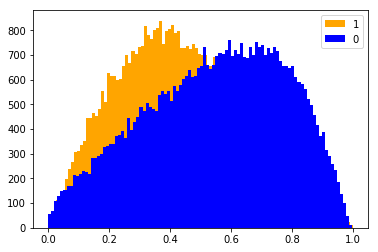

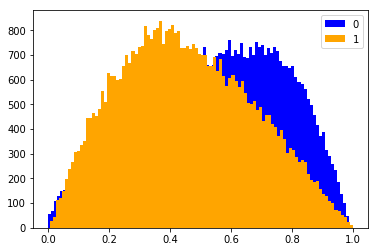

Accuracy  0.40349859148985556
Loss  0.9503093950498915
Confusion matrix
 [[19155. 28222.]
 [28315. 19089.]]
Min component variance 0.28330734372138977, median component variance 0.4287448525428772, mean component variance 0.4394680857658386, max c v 0.6798434853553772
Total length  94781


In [41]:
cls.eval()
result = validate(cls, vocab1.embeddings, vocab2.embeddings, 200, use_cuda=True)
print("Accuracy ", result[0])
print("Loss ", result[1])
print("Confusion matrix\n", result[2])
vars = result[-1].var(axis=0)
print("Min component variance {}, median component variance {}, mean component variance {}, max c v {}".format(
        min(vars), np.median(vars), np.mean(vars), max(vars)
    ))
print("Total length ", len(result[-1]))

In [42]:
# cls.discriminator.actual_model.zero_grad()

In [43]:
embeds = result[-1]

In [44]:
embeds = normalize_embeddings(embeds)

In [45]:
embeds1 = embeds[:len(vocab1.embeddings)]
embeds2 = embeds[len(vocab1.embeddings):]

/data/itasarom/torch/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


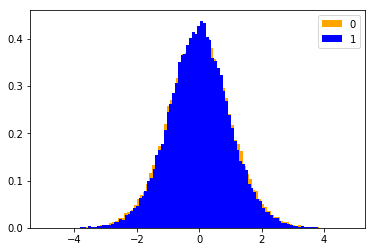

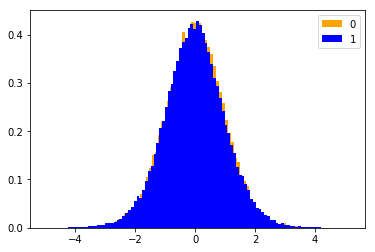

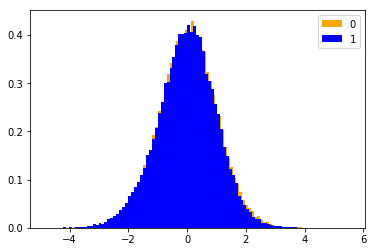

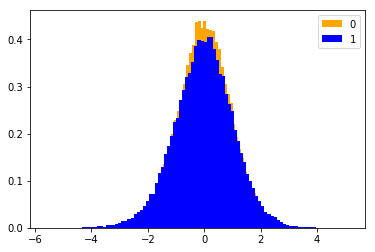

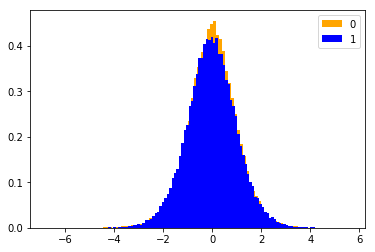

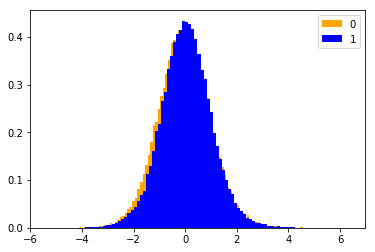

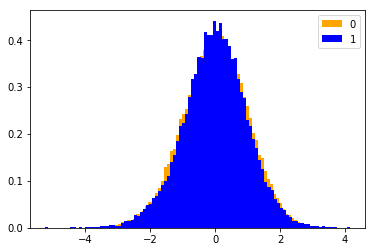

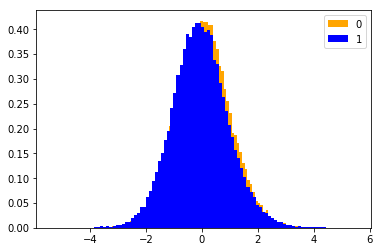

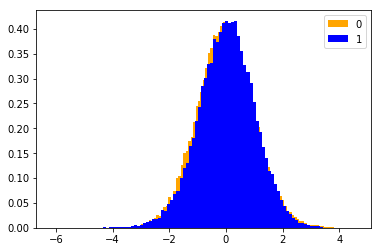

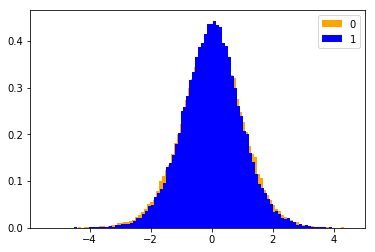

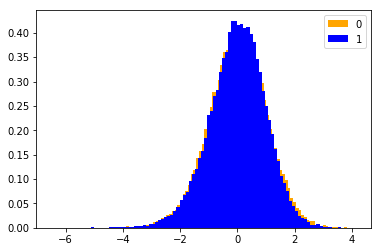

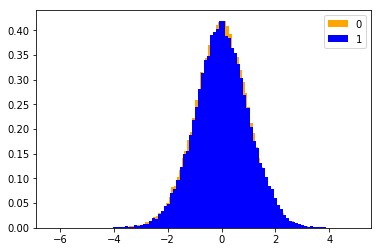

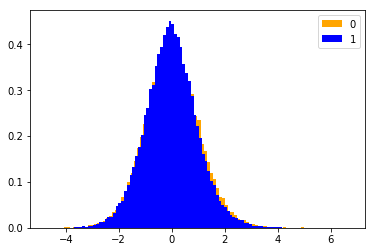

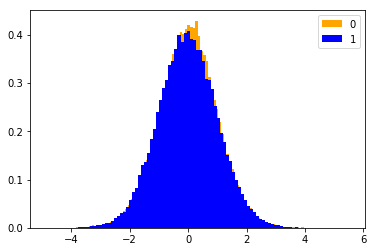

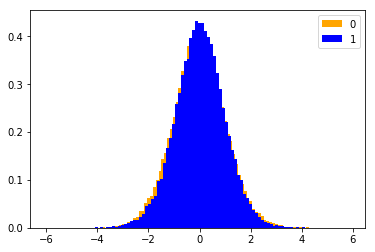

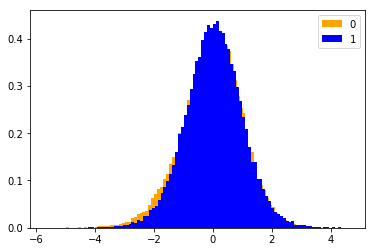

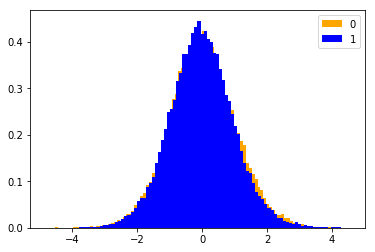

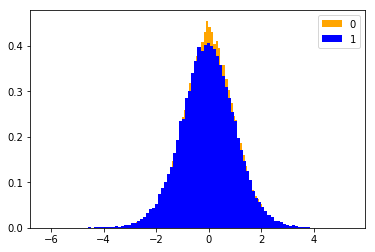

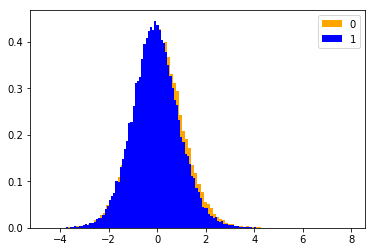

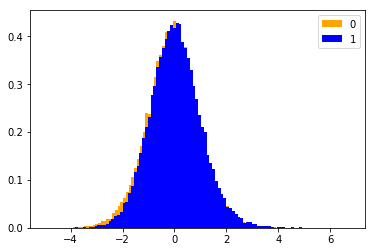

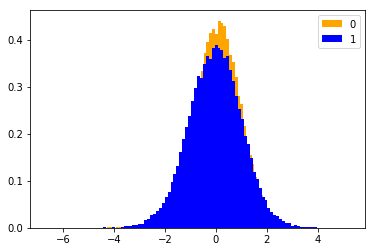

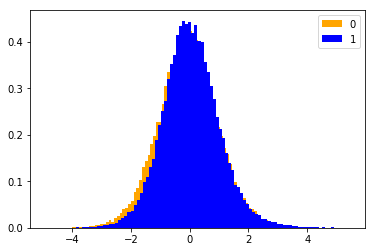

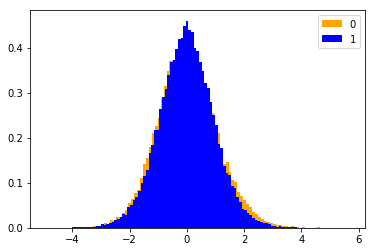

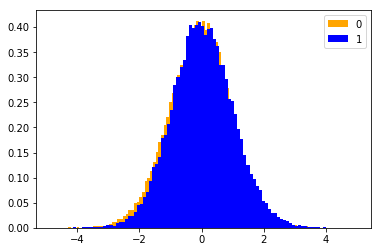

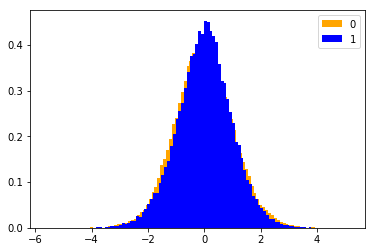

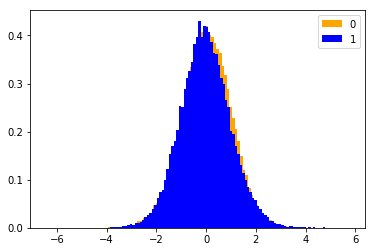

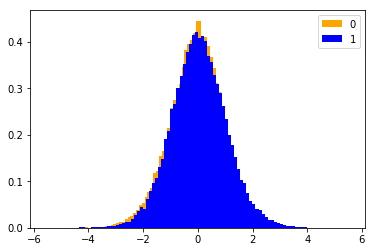

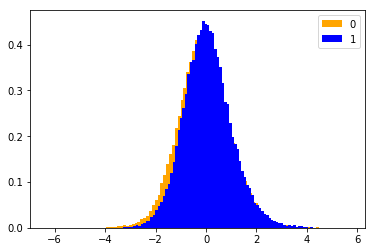

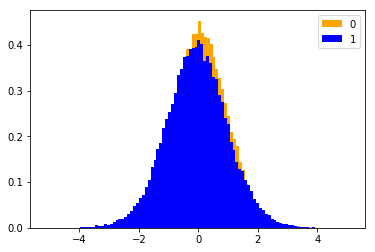

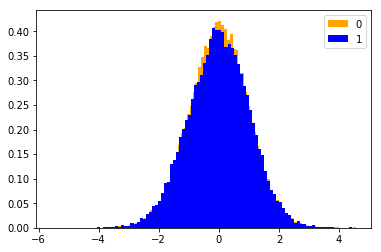

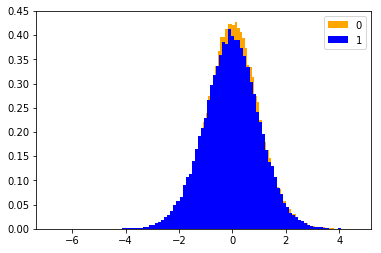

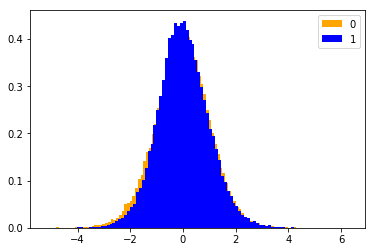

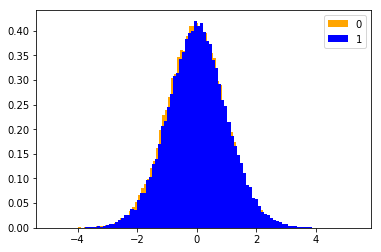

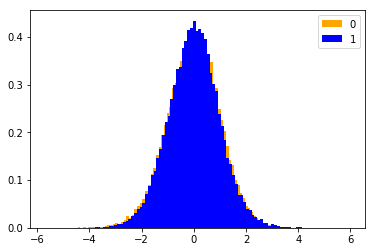

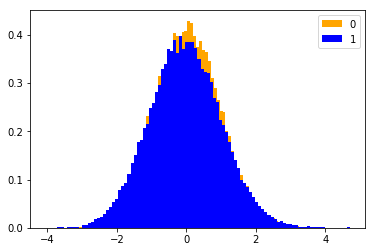

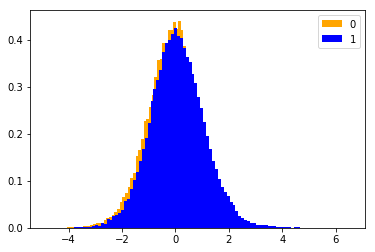

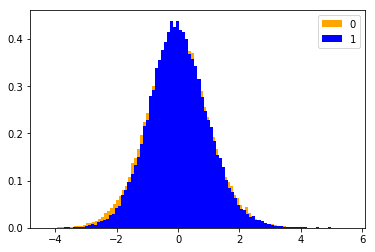

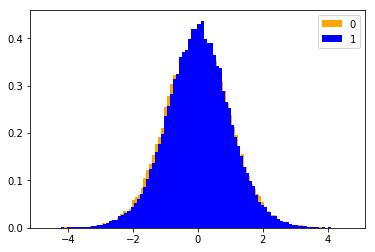

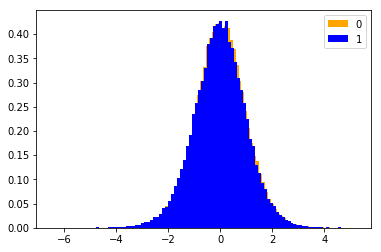

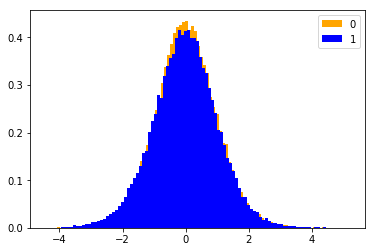

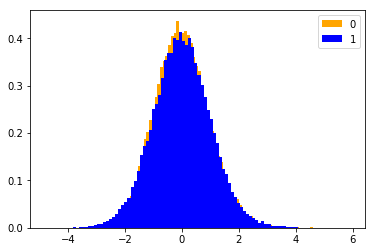

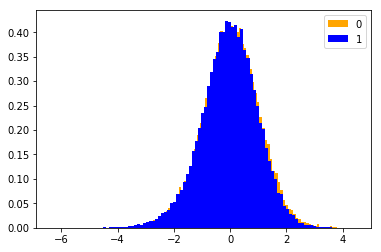

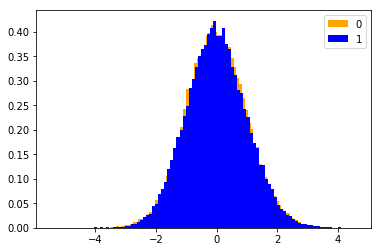

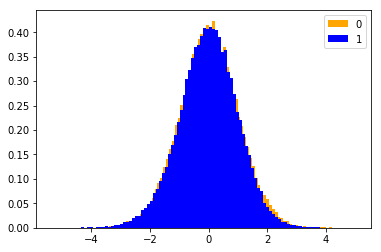

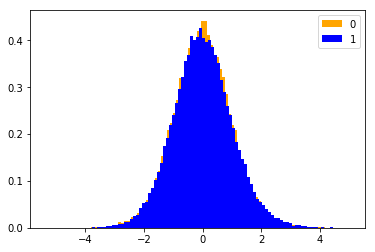

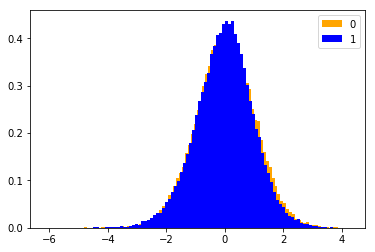

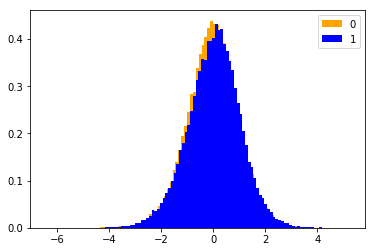

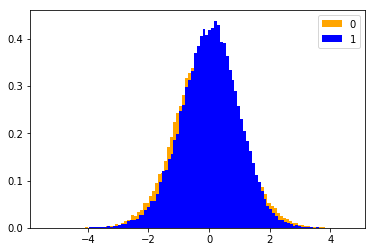

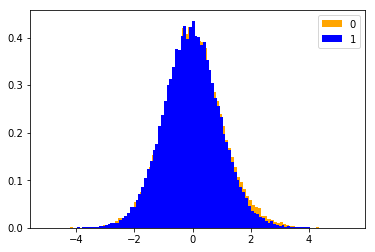

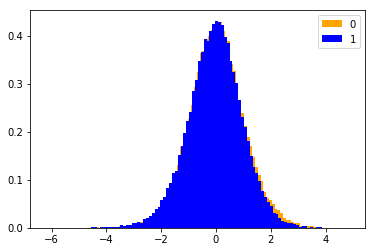

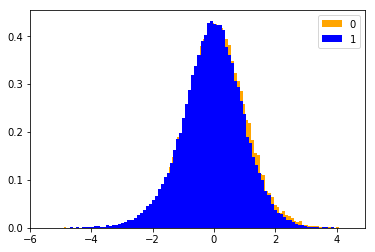

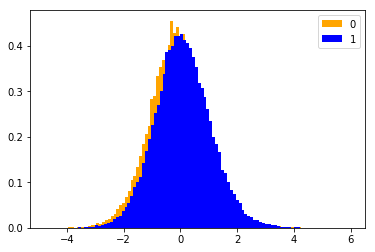

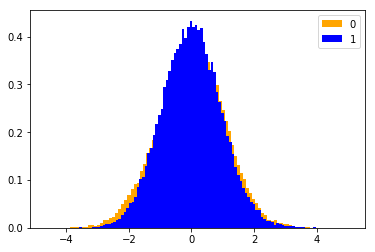

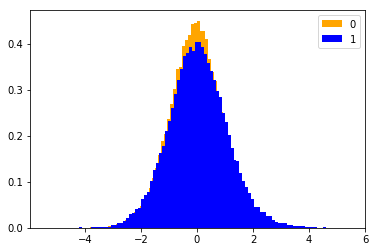

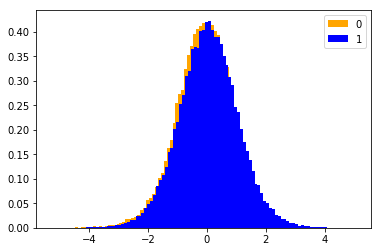

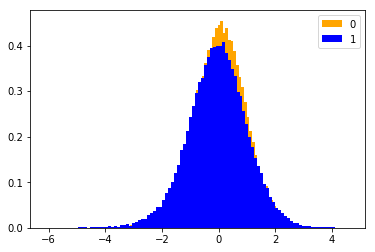

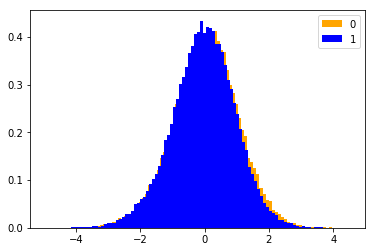

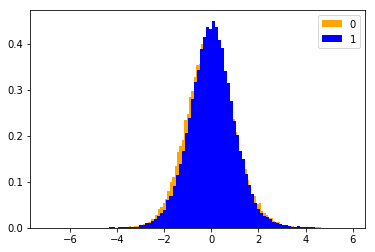

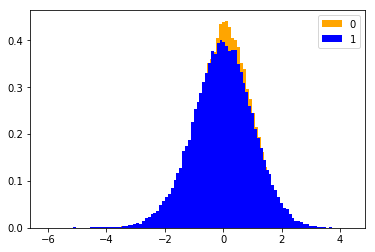

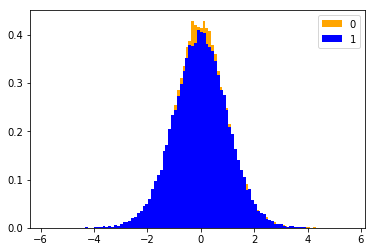

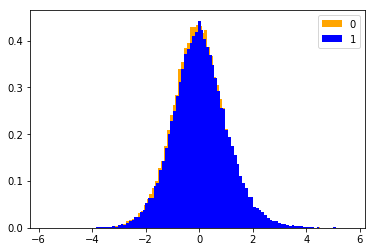

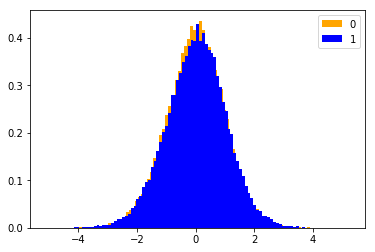

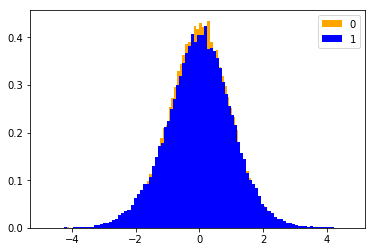

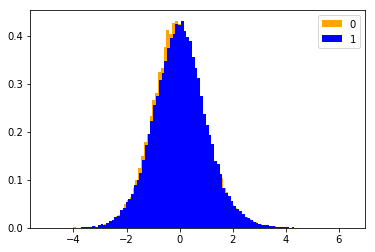

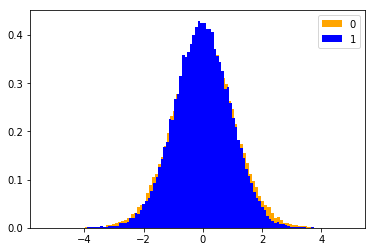

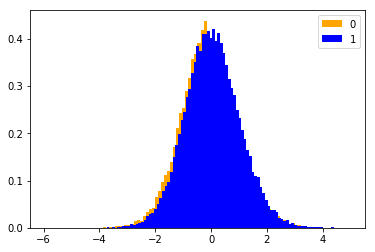

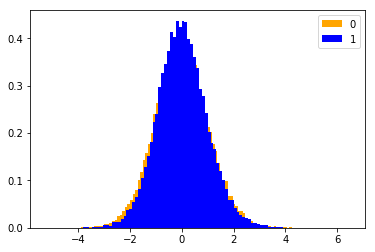

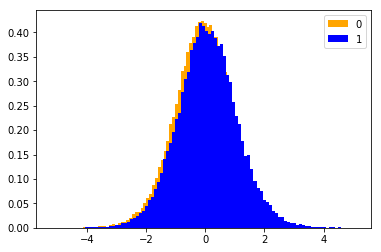

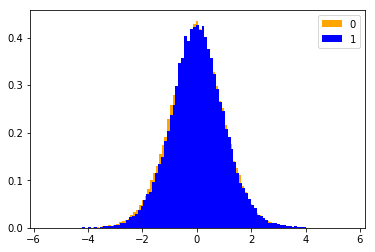

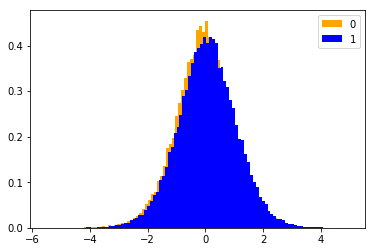

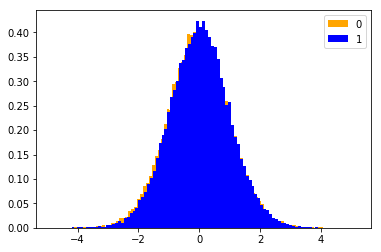

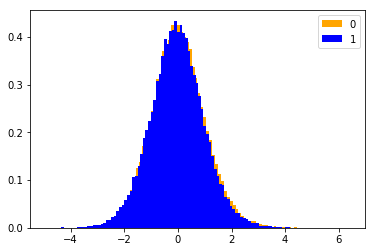

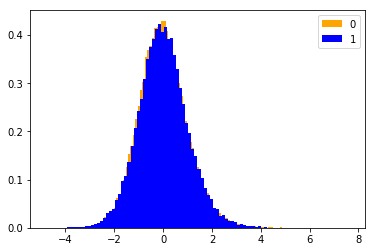

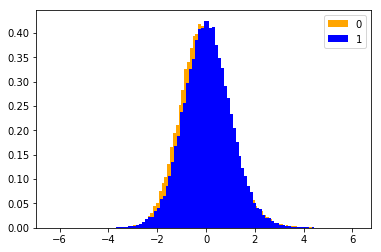

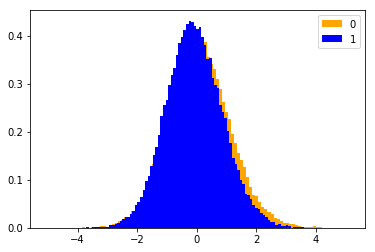

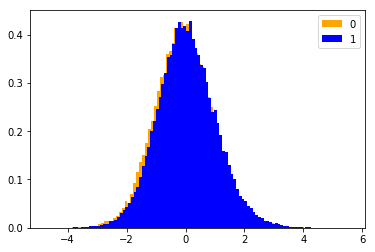

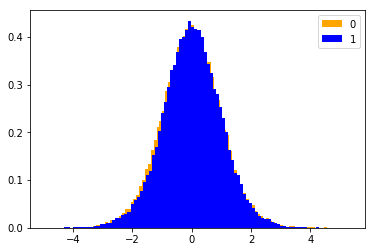

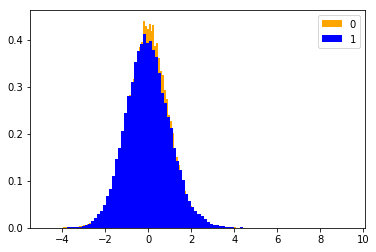

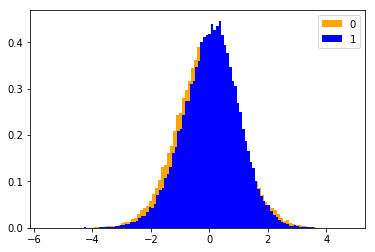

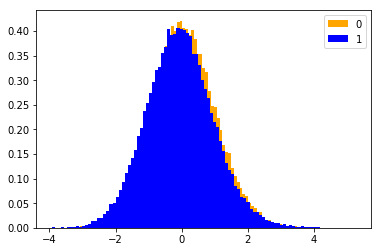

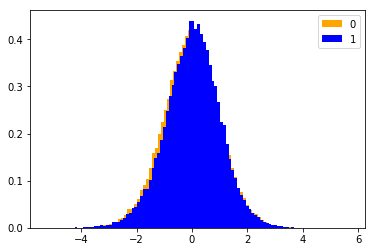

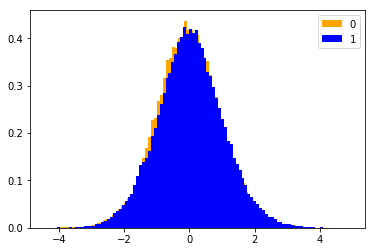

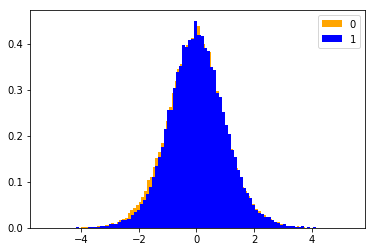

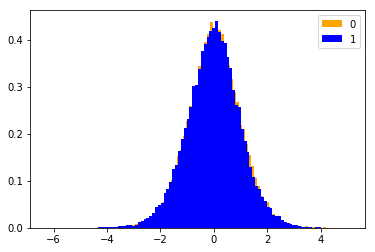

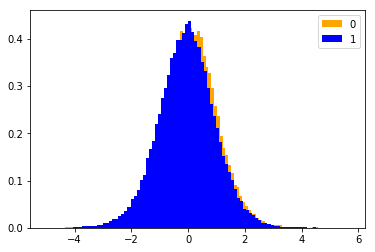

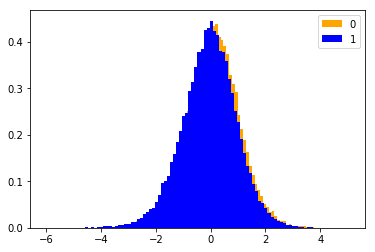

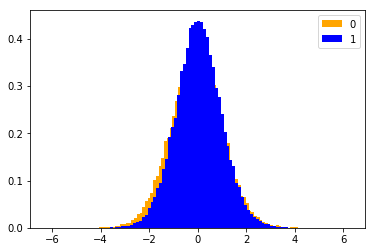

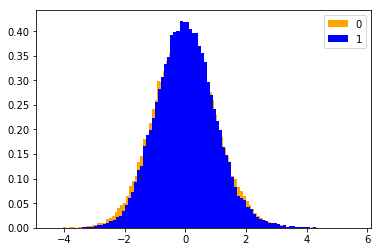

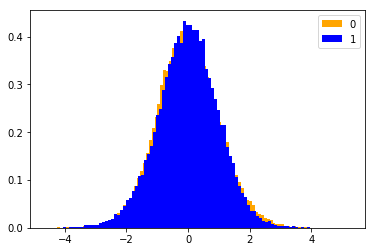

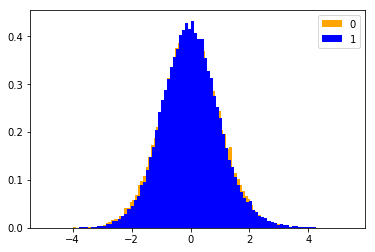

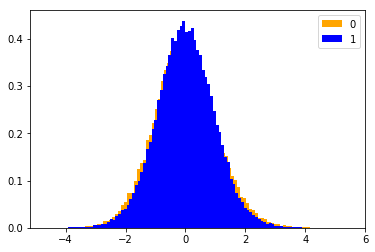

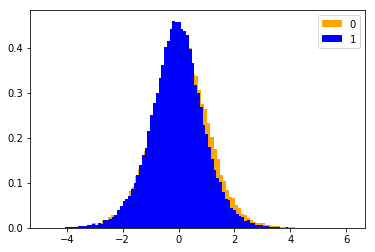

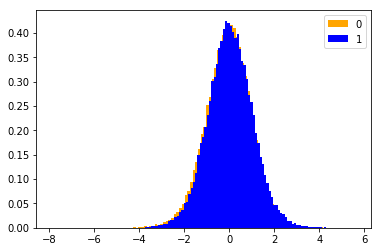

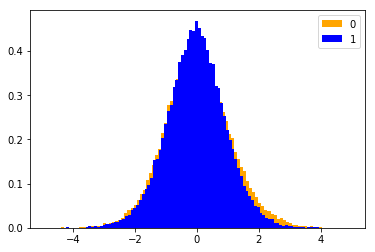

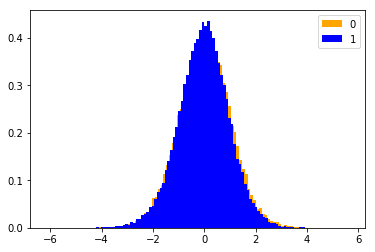

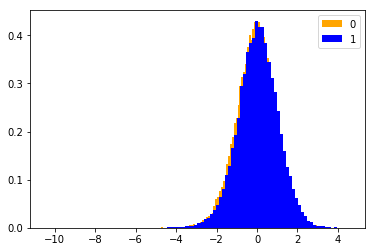

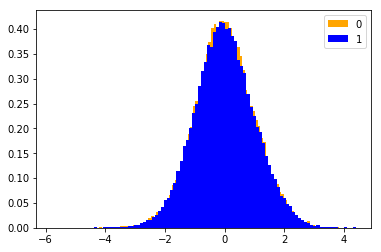

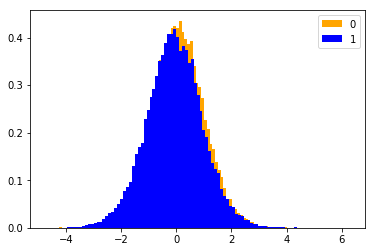

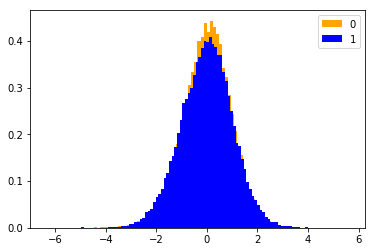

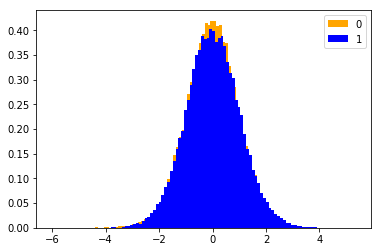

In [46]:
for i in range(100):
    plt.hist(embeds1[:, i], color='orange', bins=100, label='0', normed=True)
    plt.hist(embeds2[:, i], color='blue', bins=100, label='1', normed=True)
    plt.legend()
    plt.show()

In [47]:
import evaluation

In [48]:
def describe(sent_sampler, model, transformation):
    model.eval()
    x, mask, y = sent_sampler.get_test()
#     x, mask, y = sent_sampler.get_train_valid()
    true_y = np.zeros(shape=(len(y), len(sent_sampler.unique_labels)), dtype=np.int32)
    for idx, current_y in enumerate(y):
        true_y[idx, current_y] = 1
    
    x, mask, y = model.prepare_data_for_classifier(x, mask, y, transformation)
    
    if model.is_cuda:
        x = x.cuda()
        y = y.cuda()
        mask = mask.cuda()
    

    
    loss = model.classifier.get_loss(x, mask, y).data.cpu().numpy()
    probs = model.classifier(x, mask)[1].data.cpu().numpy()
    
    pred = np.argmax(probs, axis=1)
    
    acc = evaluation.accuracy(predicted_probs=probs, true_y=true_y)
    prec = {}
    rec = {}
    for cls in range(true_y.shape[1]):
        prec[cls] = evaluation.precision_by_class(probs, true_y, cls)
        rec[cls] = evaluation.recall_by_class(probs, true_y, cls)
    
    return acc, prec, rec, evaluation.build_confusion_matrix(probs, true_y)

    

In [49]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_1, cls, cls.transform1)

In [50]:
print(acc, len(sent_sampler_1.sents))

(761, 1024, 0.7431640625) 18641


In [51]:
print(acc, len(sent_sampler_1.sents))

(761, 1024, 0.7431640625) 18641


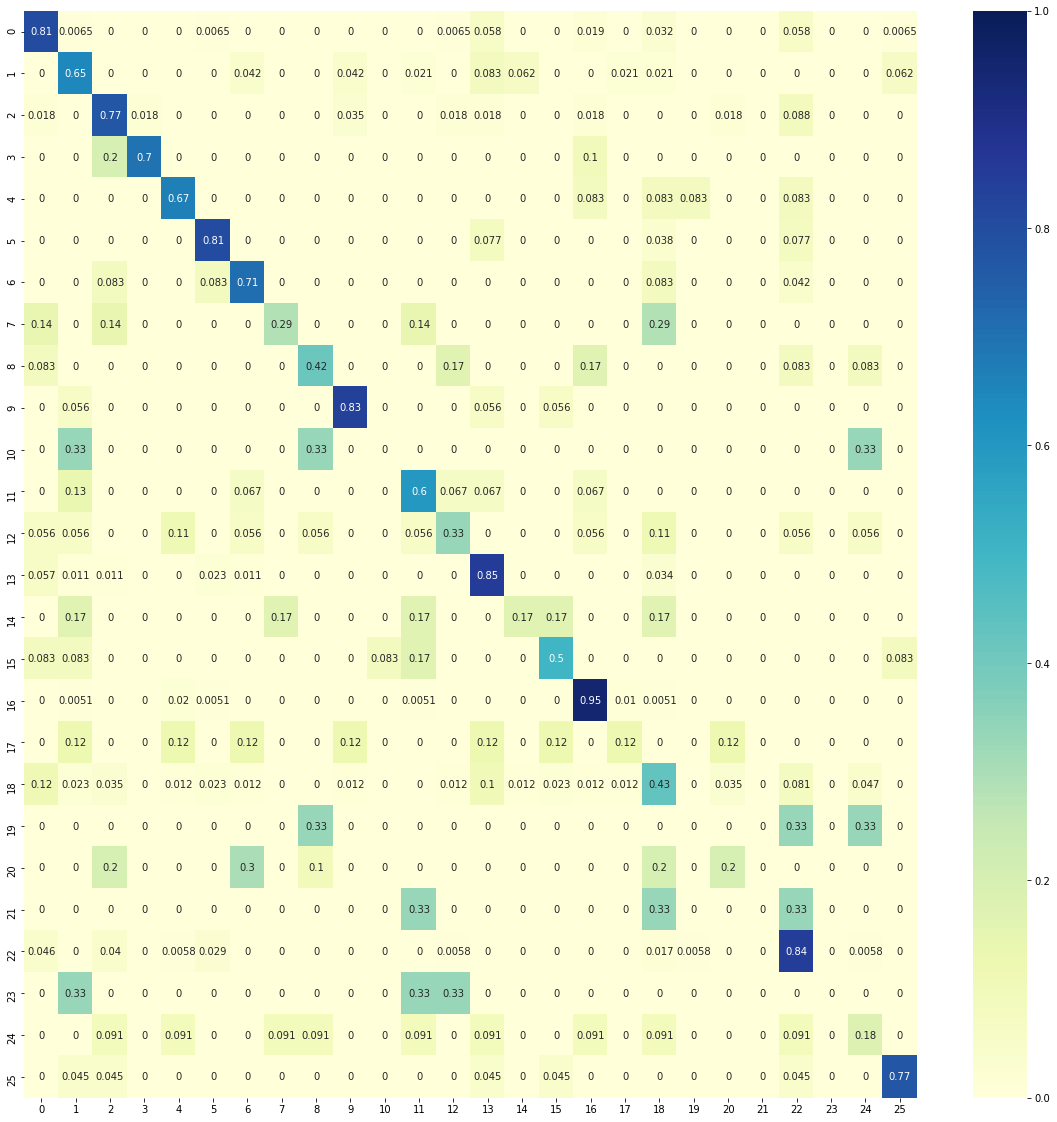

In [52]:
evaluation.plot_confusion_matrix(confusion_matrix)

In [53]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_2, cls, cls.transform2)

In [54]:
print(acc, len(sent_sampler_2.sents))

(707, 1024, 0.6904296875) 17860


In [55]:
print(acc, len(sent_sampler_2.sents))

(707, 1024, 0.6904296875) 17860


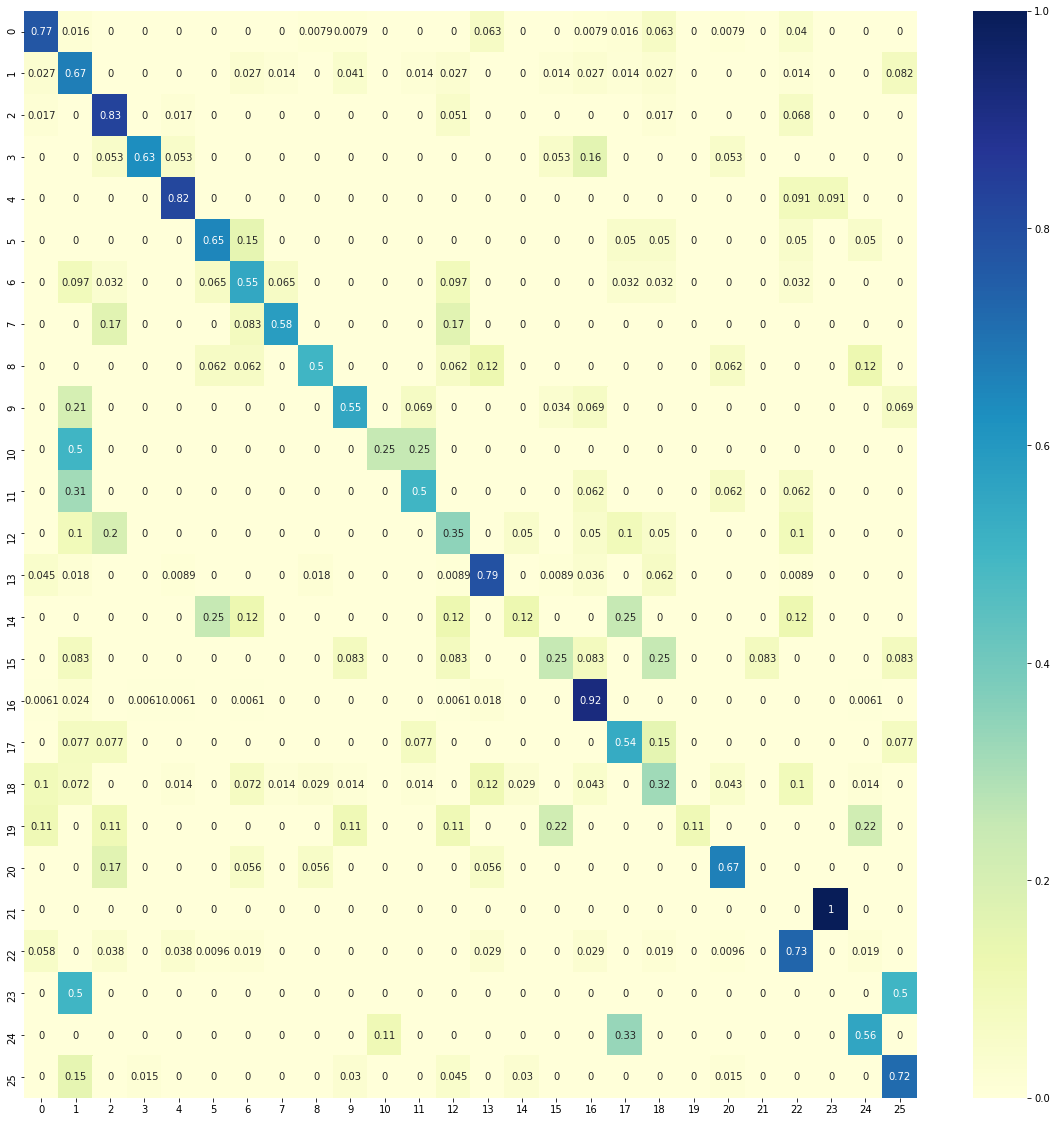

In [56]:
evaluation.plot_confusion_matrix(confusion_matrix)

In [57]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_1, cls, cls.transform2)

In [58]:
acc

(34, 1024, 0.033203125)

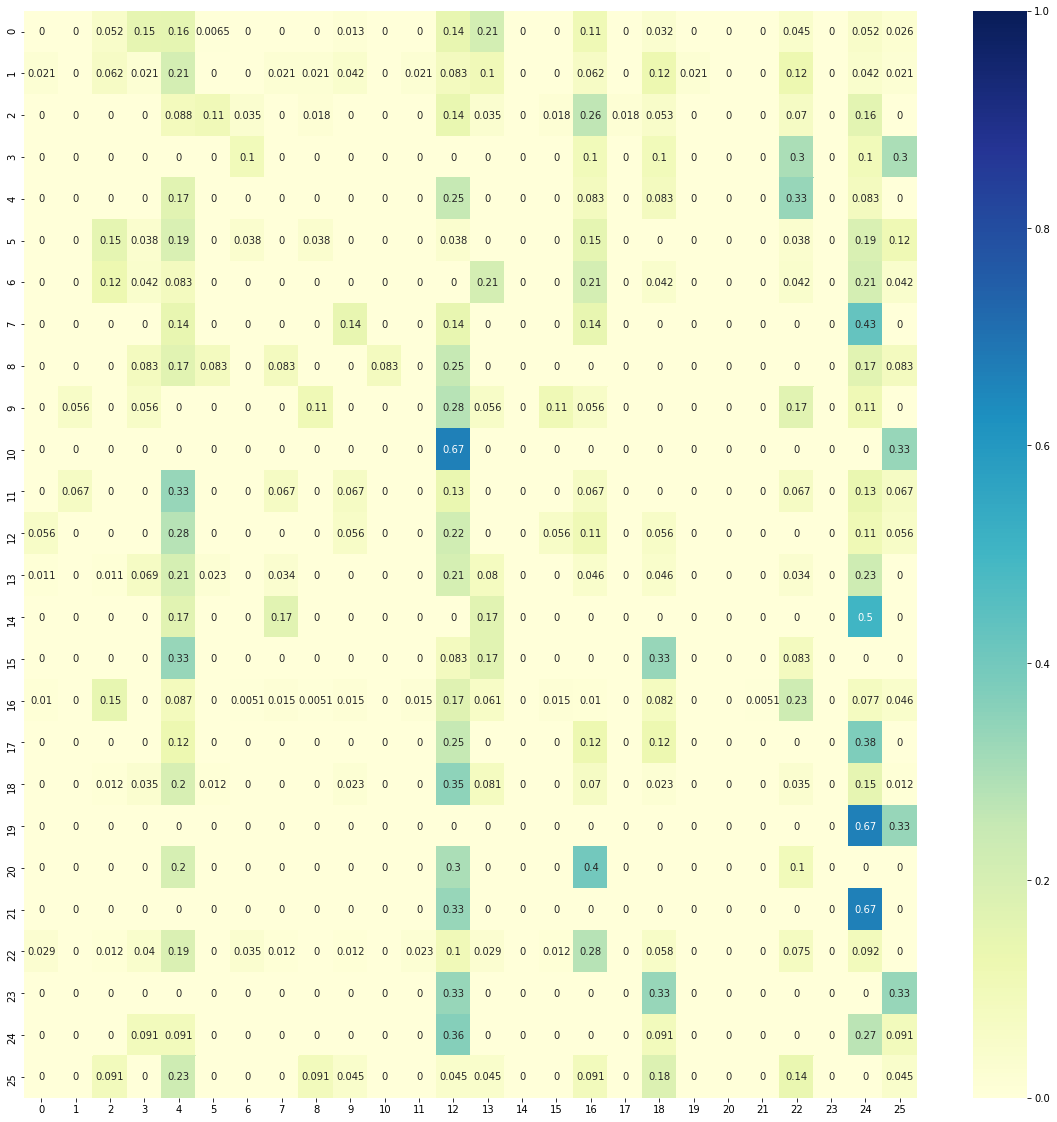

In [59]:
evaluation.plot_confusion_matrix(confusion_matrix)

In [60]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_1, cls, model.IdentityTransformation())

In [61]:
acc

(80, 1024, 0.078125)

In [62]:
f = """
aider
famille
groupe
regarder
posséder
président
haut
homme
venir
octobre
gros
chaque
chose
femme
trouver
publique
campagne
eau
gauche
bien
pays
jamais
"""
f = [w.strip() for w in f.split("\n") if len(w) > 1]

In [63]:
# s ="""
# ayudar
# familia
# grupo
# mira
# poseer
# presidente
# alto
# hombre
# venir
# octubre
# grande
# cada
# cosa
# mujer
# encontrar
# público
# campaña
# agua
# izquierda
# bueno
# país
# nunca
# """

# s = [w.strip() for w in s.split("\n") if len(w) > 1]


s = """
help
family
group
look
own
president
high
man
come
october
big
every
thing
woman
find
public
campaign
water
left
good
country
never
"""
s = [w.strip() for w in s.split("\n") if len(w) > 1]

In [64]:
# def plot_word_by_id(t1, t2, e, f, ids, dims):
#     plt.figure(figsize=(20, 20))
# #     plt.scatter(t1[ids, 0], t1[ids, 1], color='r')
# #     plt.scatter(t2[ids, 0], t2[ids, 1], color='b')
#     plt.xlim(-3, 3)
#     plt.ylim(-3, 3)
#     for id in ids:
#         plt.annotate(e[id], (t1[id, dims[0]], t1[id, dims[1]]), color='r', fontsize=15)
#         plt.annotate(f[id], (t2[id, dims[0]], t2[id, dims[1]]), color='b', fontsize=15)
# #     plt.annotate(e)
# #         print(id)
#     plt.show()

In [65]:
def get_point(id, embeds, dims):
    return embeds[id, dims[0]], embeds[id, dims[1]]

def plot_word_by_id(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2, dims, hide_original=False):
    plt.figure(figsize=(20, 20))
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)
    ind_2 = vocab2.transform_one(lang_2)
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    for id, (w1, w2) in enumerate(zip(lang_1, lang_2)):
        if not hide_original:
            plt.annotate(w1, get_point(id, orig1, dims), color='black', fontsize=15)
            plt.annotate(w2, get_point(id, orig2, dims), color='grey', fontsize=15)
        plt.annotate(w1, get_point(id, t1, dims), color='r', fontsize=15)
        plt.annotate(w2, get_point(id, t2, dims), color='b', fontsize=15)

        
        
#     plt.annotate(e)
#         print(id)
    plt.show()

In [66]:
# plot_word_by_id(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, dims=[12, 49], hide_original=True)

In [67]:
# e = """
# help
# family
# group
# look
# own
# president
# high
# man
# come
# october
# big
# every
# thing
# woman
# find
# public
# campaign
# water
# left
# good
# country
# never
# """
# e = [w.strip() for w in e.split("\n") if len(w) > 1]

In [68]:
# f = """
# aider
# famille
# groupe
# regarder
# posséder
# président
# haut
# homme
# venir
# octobre
# gros
# chaque
# chose
# femme
# trouver
# publique
# campagne
# eau
# gauche
# bien
# pays
# jamais
# """
# f = [w.strip() for w in f.split("\n") if len(w) > 1]

In [69]:
# cls = cls.cpu()
from sklearn.decomposition import PCA

In [70]:
def get_point_pca(id, embeds):
    return embeds[id, 0], embeds[id, 1]

def plot_words_pca(pca, vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2, hide_original=False):
    plt.figure(figsize=(20, 20))
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)
    ind_2 = vocab2.transform_one(lang_2)
    
    orig1 = pca.transform(orig1[ind_1])
    orig2 = pca.transform(orig2[ind_2])
    t1 = pca.transform(t1[ind_1])
    t2 = pca.transform(t2[ind_2])
    
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    for id, (w1, w2) in enumerate(zip(lang_1, lang_2)):
        
        if not hide_original:
            plt.annotate(w1, get_point_pca(id, orig1), color='black', fontsize=15)
            plt.annotate(w2, get_point_pca(id, orig2), color='grey', fontsize=15)
        plt.annotate(w1, get_point_pca(id, t1), color='r', fontsize=15)
        plt.annotate(w2, get_point_pca(id, t2), color='b', fontsize=15)
        
        
#     plt.annotate(e)
#         print(id)
    plt.show()

In [71]:
# pca1 = PCA(n_components=2)
# pca1.fit(vocab1.embeddings)

In [72]:
# pca2 = PCA(n_components=2)
# pca2.fit(vocab2.embeddings)

In [73]:
# pca3 = PCA(n_components=2)
# pca3.fit(embeds1)

In [74]:
# pca4 = PCA(n_components=2)
# pca4.fit(embeds2)

In [75]:
pca = PCA(n_components=2)
pca.fit(np.vstack([embeds1, embeds2]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

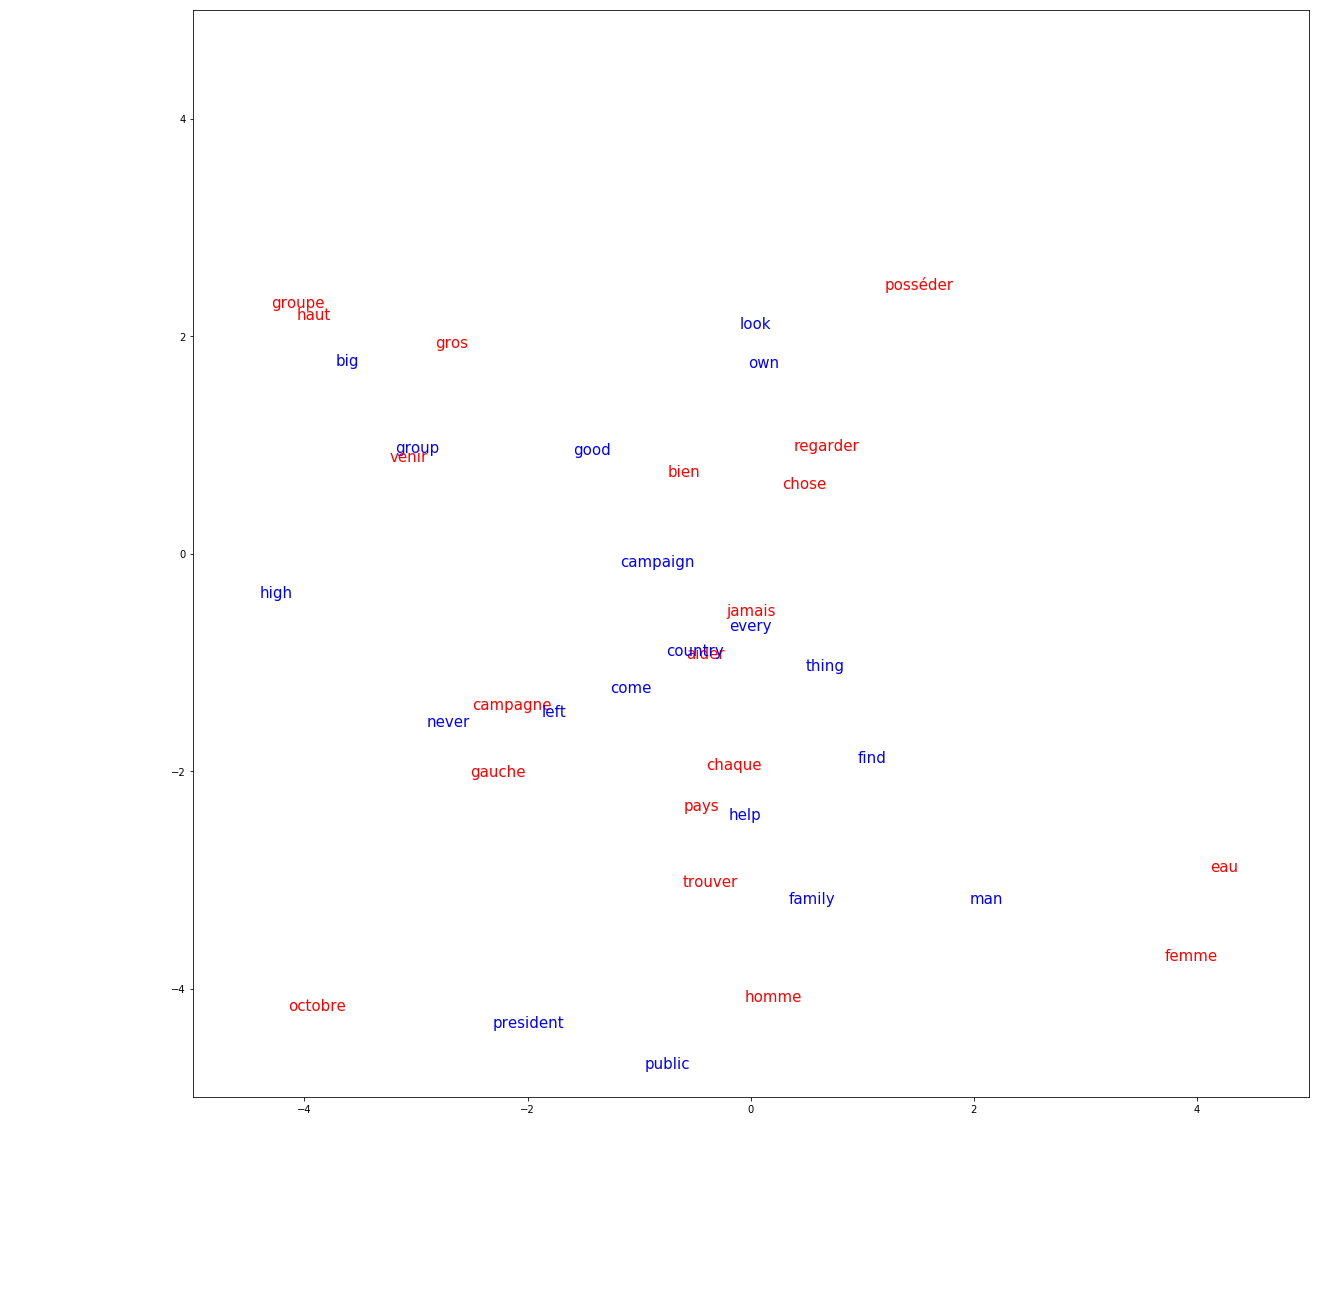

In [76]:
plot_words_pca(pca, vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, hide_original=True)

In [77]:
from sklearn.metrics.pairwise import cosine_similarity

In [78]:
import seaborn as sns

In [79]:
# f

In [80]:
def cos(a, b):
    a = a/(a**2).sum(axis=1, keepdims=True)**0.5
    b = b/(b**2).sum(axis=1, keepdims=True)**0.5
    
    return (a * b).sum(axis=1)

def cosine_metrics(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    before = cos(orig1, orig2)
    after = cos(t1, t2)
    
    print("{}|{}|{}|{}".format("lang1", "lang2", "before", "after", fill=' ', align='<', width=10))
    for w1, w2, c1, c2 in zip(lang_1, lang_2, before, after):
        print("{}|{}|{:.4f}|{:.4f}".format(w1, w2, c1, c2, fill=' ', align='<', width=10))
    
    c1 = cosine_similarity(orig1, orig2)
    c2 = cosine_similarity(t1, t2)
    plt.figure(figsize=(15, 15))
    sns.heatmap(c1, vmin=-1.0, vmax=1.0, square=True)
    plt.show()
    plt.figure(figsize=(15, 15))
    sns.heatmap(c2, vmin=-1.0, vmax=1.0, square=True)
    plt.show()
    
    plt.figure(figsize=(15, 15))
    sns.heatmap(c2 - c1)
    plt.show()
    
#     print(t1.shape, t2.shape)
#     print(c2.shape)
    s = 0
    for id, w1 in enumerate(lang_1):
#         print(c2[id].argmax())
        translation = lang_2[c2[id].argmax()]
        if translation == lang_2[id]:
            res = "OK"
        else:
            res = "Fail"
        s += translation == lang_2[id]
        print("{} --> {} ({})".format(w1, translation, res))
        
    print(s/len(lang_1))
#     plt.figure(figsize=(15, 15))
#     sns.heatmap((c2 - c1 > 0.1).astype(np.float32))
#     plt.show()
#     print(np.diag(c2))
#     print(np.diag(c1))
#     print()


In [81]:

def word_translation_cosine(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    c1 = cosine_similarity(orig1, orig2)
    c2 = cosine_similarity(t1, t2)
    
    count = 0
    for id, w1 in enumerate(lang_1):
        translation = lang_2[c2[id].argmax()]
        if translation == lang_2[id]:
            res = "OK"
        else:
            res = "Fail"
        count += translation == lang_2[id]
        print("{} --> {} ({})".format(w1, translation, res))
        
    print(count/len(lang_1))
    
    count = 0
    for id, w2 in enumerate(lang_2):
        translation = lang_1[c2[:, id].argmax()]
        if translation == lang_1[id]:
            res = "OK"
        else:
            res = "Fail"
        count += translation == lang_1[id]
        print("{} --> {} ({})".format(w2, translation, res))
        
    print(count/len(lang_2))



In [82]:
word_translation_cosine(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s)

aider --> find (Fail)
famille --> public (Fail)
groupe --> big (Fail)
regarder --> find (Fail)
posséder --> every (Fail)
président --> president (OK)
haut --> come (Fail)
homme --> man (OK)
venir --> every (Fail)
octobre --> october (OK)
gros --> big (OK)
chaque --> every (OK)
chose --> come (Fail)
femme --> woman (OK)
trouver --> find (OK)
publique --> president (Fail)
campagne --> president (Fail)
eau --> water (OK)
gauche --> president (Fail)
bien --> never (Fail)
pays --> campaign (Fail)
jamais --> never (OK)
0.4090909090909091
help --> trouver (Fail)
family --> femme (Fail)
group --> groupe (OK)
look --> bien (Fail)
own --> bien (Fail)
president --> président (OK)
high --> groupe (Fail)
man --> homme (OK)
come --> bien (Fail)
october --> octobre (OK)
big --> groupe (Fail)
every --> chaque (OK)
thing --> aider (Fail)
woman --> femme (OK)
find --> trouver (OK)
public --> famille (Fail)
campaign --> campagne (OK)
water --> eau (OK)
left --> trouver (Fail)
good --> aider (Fail)
countr

lang1|lang2|before|after
aider|help|0.1497|0.4041
famille|family|-0.0352|0.3429
groupe|group|-0.0241|0.4222
regarder|look|0.0725|0.2552
posséder|own|0.0859|0.1517
président|president|0.0013|0.5902
haut|high|0.1111|0.1643
homme|man|0.0777|0.5064
venir|come|0.1197|0.0780
octobre|october|0.0307|0.3100
gros|big|-0.0656|0.3856
chaque|every|0.1538|0.5095
chose|thing|0.2506|0.1757
femme|woman|0.0529|0.5635
trouver|find|0.1031|0.6001
publique|public|0.1366|0.3868
campagne|campaign|-0.0845|0.4866
eau|water|-0.0158|0.5909
gauche|left|0.0135|0.0911
bien|good|0.0601|0.3934
pays|country|0.0388|0.3469
jamais|never|0.1138|0.3139


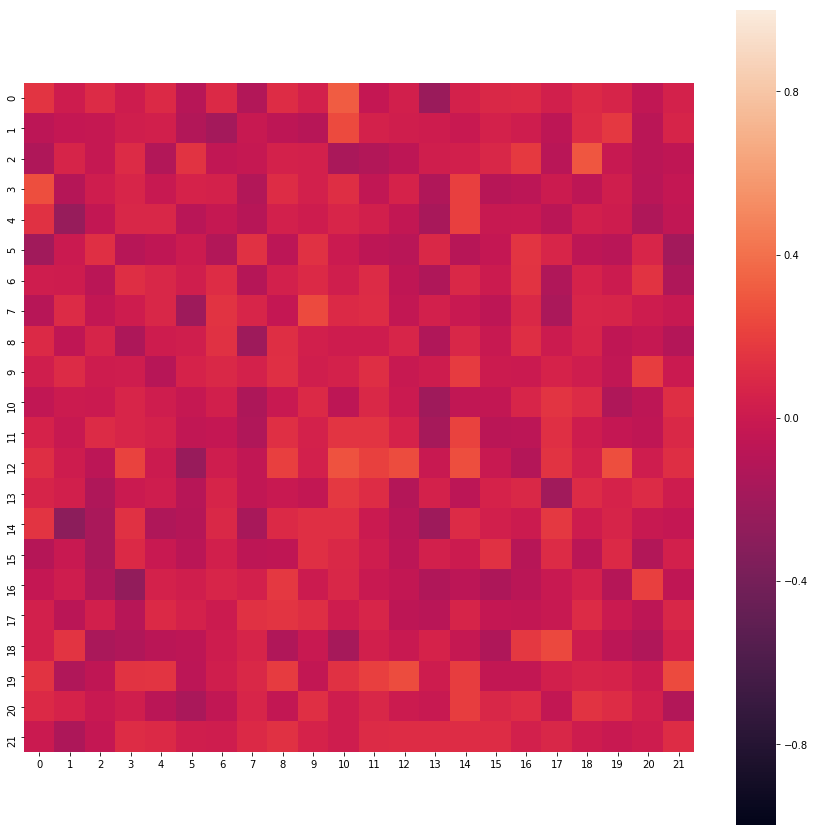

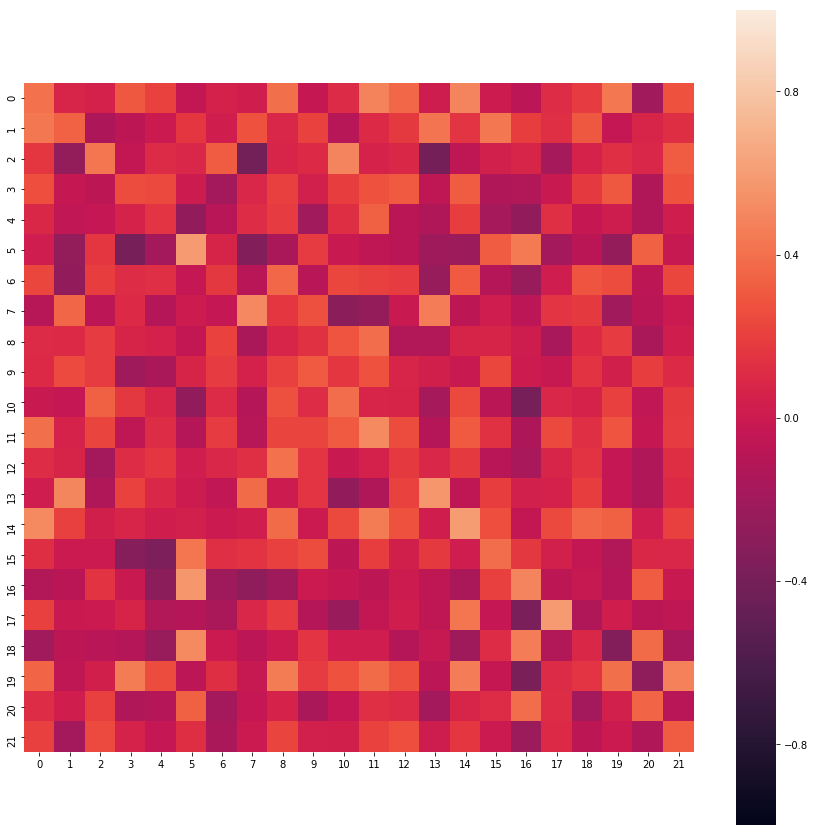

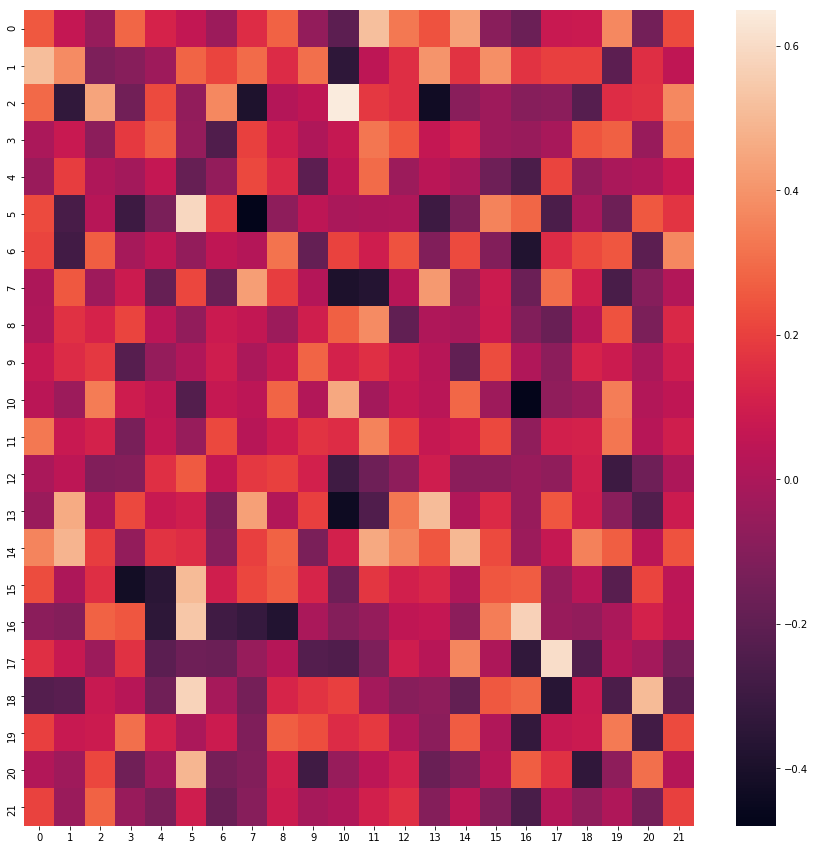

aider --> find (Fail)
famille --> public (Fail)
groupe --> big (Fail)
regarder --> find (Fail)
posséder --> every (Fail)
président --> president (OK)
haut --> come (Fail)
homme --> man (OK)
venir --> every (Fail)
octobre --> october (OK)
gros --> big (OK)
chaque --> every (OK)
chose --> come (Fail)
femme --> woman (OK)
trouver --> find (OK)
publique --> president (Fail)
campagne --> president (Fail)
eau --> water (OK)
gauche --> president (Fail)
bien --> never (Fail)
pays --> campaign (Fail)
jamais --> never (OK)
0.4090909090909091


In [83]:
cosine_metrics(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s)

In [84]:
# vocab1.transformation

In [85]:
import os
def read_facebook_dict(path, file_name, vocab1, vocab2):
    path = os.path.join(path, file_name)
    
    lang_1 = []
    lang_2 = []
    with open(path, "r") as f:
        for line in f:
            a, b = line.strip().split(" ")
            if a in vocab1.transformation and b in vocab2.transformation:
                lang_1.append(a)
                lang_2.append(b)
                
    return lang_1, lang_2

In [86]:
def word_translation_cosine_silent(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2,ks,  use_transformed=True,):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    if use_transformed:
        similarity = cosine_similarity(t1, t2)
    else:
        similarity = cosine_similarity(orig1, orig2)
        
    
    counts1 = {k:0 for k in ks}
    for id, w1 in enumerate(lang_1):
        candidate_ids = (-similarity[id]).argsort()
        for k in ks:
            if id in candidate_ids[:k]:
                counts1[k] += 1
        
    counts2 = {k:0 for k in ks}
    for id, w2 in enumerate(lang_2):
        candidate_ids = (-similarity[:, id]).argsort()
        for k in ks:
            if id in candidate_ids[:k]:
                counts2[k] += 1
        
#     res_for_lang_2 = count/len(lang_2)
    
#     return res_for_lang_1, res_for_lang_2
    for k in ks:
        counts1[k] /= len(lang_1)
        counts2[k] /= len(lang_2)
        
    return counts1, counts2


In [87]:
word_translation_cosine_silent(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500,1000, 2000])

({1: 0.4090909090909091,
  2: 0.5909090909090909,
  3: 0.6363636363636364,
  4: 0.7727272727272727,
  5: 0.8181818181818182,
  6: 0.8636363636363636,
  7: 0.9090909090909091,
  8: 0.9090909090909091,
  9: 0.9090909090909091,
  10: 0.9545454545454546,
  50: 1.0,
  100: 1.0,
  200: 1.0,
  500: 1.0,
  1000: 1.0,
  2000: 1.0},
 {1: 0.4090909090909091,
  2: 0.5909090909090909,
  3: 0.7727272727272727,
  4: 0.7727272727272727,
  5: 0.8636363636363636,
  6: 0.8636363636363636,
  7: 0.8636363636363636,
  8: 0.8636363636363636,
  9: 0.9090909090909091,
  10: 0.9090909090909091,
  50: 1.0,
  100: 1.0,
  200: 1.0,
  500: 1.0,
  1000: 1.0,
  2000: 1.0})

In [88]:
lang_1, lang_2 = read_facebook_dict("../crosslingual/dictionaries/", "fr-en.5000-6500.txt", vocab1, vocab2)

In [89]:
word_translation_cosine_silent(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, lang_1, lang_2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500,1000, 2000])

({1: 0.032388663967611336,
  2: 0.06275303643724696,
  3: 0.08552631578947369,
  4: 0.10222672064777327,
  5: 0.11842105263157894,
  6: 0.13309716599190283,
  7: 0.1417004048582996,
  8: 0.1533400809716599,
  9: 0.16447368421052633,
  10: 0.17510121457489877,
  50: 0.3689271255060729,
  100: 0.4873481781376518,
  200: 0.6103238866396761,
  500: 0.7909919028340081,
  1000: 0.9159919028340081,
  2000: 1.0},
 {1: 0.034919028340080975,
  2: 0.06578947368421052,
  3: 0.09210526315789473,
  4: 0.11082995951417005,
  5: 0.12550607287449392,
  6: 0.1396761133603239,
  7: 0.1492914979757085,
  8: 0.16143724696356276,
  9: 0.1771255060728745,
  10: 0.1867408906882591,
  50: 0.38208502024291496,
  100: 0.4873481781376518,
  200: 0.604757085020243,
  500: 0.7970647773279352,
  1000: 0.9154858299595142,
  2000: 1.0})

In [90]:
def word_translation_cosine_complete(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2,ks,  use_transformed=True,):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    orig1_complete = orig1
    orig2_complete = orig2
    t1_complete = t1
    t2_complete = t2
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    if use_transformed:
        similarity_1_2 = cosine_similarity(t1, t2_complete)
        similarity_2_1 = cosine_similarity(t2, t1_complete)
    else:
        similarity_1_2 = cosine_similarity(orig1, orig2_complete)
        similarity_2_1 = cosine_similarity(orig2, orig1_complete)
        
    
    counts1 = {k:0 for k in ks}
    for id, w1 in enumerate(lang_1):
        translation_id = vocab2.words.index(lang_2[id])
        candidate_ids = (-similarity_1_2[id]).argsort()
        for k in ks:
            if translation_id in candidate_ids[:k]:
                counts1[k] += 1
        
    counts2 = {k:0 for k in ks}
    for id, w2 in enumerate(lang_2):
        translation_id = vocab1.words.index(lang_1[id])
        candidate_ids = (-similarity_2_1[id]).argsort()
        for k in ks:
            if translation_id in candidate_ids[:k]:
                counts2[k] += 1
        
#     res_for_lang_2 = count/len(lang_2)
    
#     return res_for_lang_1, res_for_lang_2
    for k in ks:
        counts1[k] /= len(lang_1)
        counts2[k] /= len(lang_2)
        
    return counts1, counts2


In [91]:
word_translation_cosine_complete(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, lang_1, lang_2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], use_transformed=False)

({1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  50: 0.0020242914979757085,
  100: 0.003036437246963563,
  200: 0.006072874493927126,
  500: 0.01568825910931174,
  1000: 0.02834008097165992,
  2000: 0.05212550607287449,
  5000: 0.12398785425101215,
  10000: 0.2236842105263158,
  20000: 0.4640688259109312,
  50000: 1.0},
 {1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  50: 0.0015182186234817814,
  100: 0.0025303643724696357,
  200: 0.006072874493927126,
  500: 0.016194331983805668,
  1000: 0.02834008097165992,
  2000: 0.05161943319838057,
  5000: 0.11993927125506072,
  10000: 0.22317813765182187,
  20000: 0.465080971659919,
  50000: 1.0})

In [92]:
word_translation_cosine_complete(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, lang_1, lang_2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], use_transformed=True)

({1: 0.004554655870445344,
  2: 0.006578947368421052,
  3: 0.009615384615384616,
  4: 0.011133603238866396,
  5: 0.013157894736842105,
  6: 0.015182186234817813,
  7: 0.016700404858299597,
  8: 0.019736842105263157,
  9: 0.02125506072874494,
  10: 0.02479757085020243,
  50: 0.076417004048583,
  100: 0.11690283400809717,
  200: 0.16649797570850203,
  500: 0.26417004048583,
  1000: 0.3441295546558704,
  2000: 0.4534412955465587,
  5000: 0.6174089068825911,
  10000: 0.7550607287449392,
  20000: 0.8906882591093117,
  50000: 1.0},
 {1: 0.00354251012145749,
  2: 0.005566801619433198,
  3: 0.00708502024291498,
  4: 0.009109311740890687,
  5: 0.012651821862348178,
  6: 0.015182186234817813,
  7: 0.01720647773279352,
  8: 0.018724696356275303,
  9: 0.022267206477732792,
  10: 0.025809716599190284,
  50: 0.07995951417004049,
  100: 0.12246963562753037,
  200: 0.18168016194331985,
  500: 0.2742914979757085,
  1000: 0.35728744939271256,
  2000: 0.4610323886639676,
  5000: 0.6153846153846154,
  100

In [93]:
dp.write_embeds("./embeds_fr.vec", embeds1, vocab1.words)

In [94]:
dp.write_embeds("./embeds_en.vec", embeds2, vocab2.words)

In [95]:
s = """
2010
2011
2012
2013
2014
2015
2016
2017
2018
january
february
march
april
may
june
july
august
september
october
november
december
"""
s = [w.strip() for w in s.split("\n") if len(w) > 1]

In [96]:
f = """
2010
2011
2012
2013
2014
2015
2016
2017
2018
janvier
février
mars
avril
mai
juin
juillet
aout
septembre
octobre
novembre
décembre
"""
f = [w.strip() for w in f.split("\n") if len(w) > 1]

In [97]:
word_translation_cosine_complete(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], use_transformed=True)

({1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  50: 0.09523809523809523,
  100: 0.09523809523809523,
  200: 0.09523809523809523,
  500: 0.23809523809523808,
  1000: 0.38095238095238093,
  2000: 0.47619047619047616,
  5000: 0.8095238095238095,
  10000: 0.9047619047619048,
  20000: 0.9523809523809523,
  50000: 1.0},
 {1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  50: 0.09523809523809523,
  100: 0.09523809523809523,
  200: 0.09523809523809523,
  500: 0.14285714285714285,
  1000: 0.19047619047619047,
  2000: 0.3333333333333333,
  5000: 0.6666666666666666,
  10000: 0.8571428571428571,
  20000: 0.9523809523809523,
  50000: 1.0})

In [98]:
word_translation_cosine(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s)

2010 --> march (Fail)
2011 --> may (Fail)
2012 --> july (Fail)
2013 --> april (Fail)
2014 --> 2016 (Fail)
2015 --> may (Fail)
2016 --> 2016 (OK)
2017 --> 2018 (Fail)
2018 --> 2018 (OK)
janvier --> 2014 (Fail)
février --> march (Fail)
mars --> july (Fail)
avril --> march (Fail)
mai --> november (Fail)
juin --> july (Fail)
juillet --> july (OK)
aout --> may (Fail)
septembre --> 2014 (Fail)
octobre --> 2015 (Fail)
novembre --> september (Fail)
décembre --> july (Fail)
0.14285714285714285
2010 --> décembre (Fail)
2011 --> novembre (Fail)
2012 --> décembre (Fail)
2013 --> novembre (Fail)
2014 --> novembre (Fail)
2015 --> novembre (Fail)
2016 --> 2016 (OK)
2017 --> 2017 (OK)
2018 --> 2017 (Fail)
january --> novembre (Fail)
february --> novembre (Fail)
march --> novembre (Fail)
april --> décembre (Fail)
may --> décembre (Fail)
june --> 2013 (Fail)
july --> décembre (Fail)
august --> 2012 (Fail)
september --> novembre (Fail)
october --> mai (Fail)
november --> novembre (OK)
december --> novemb

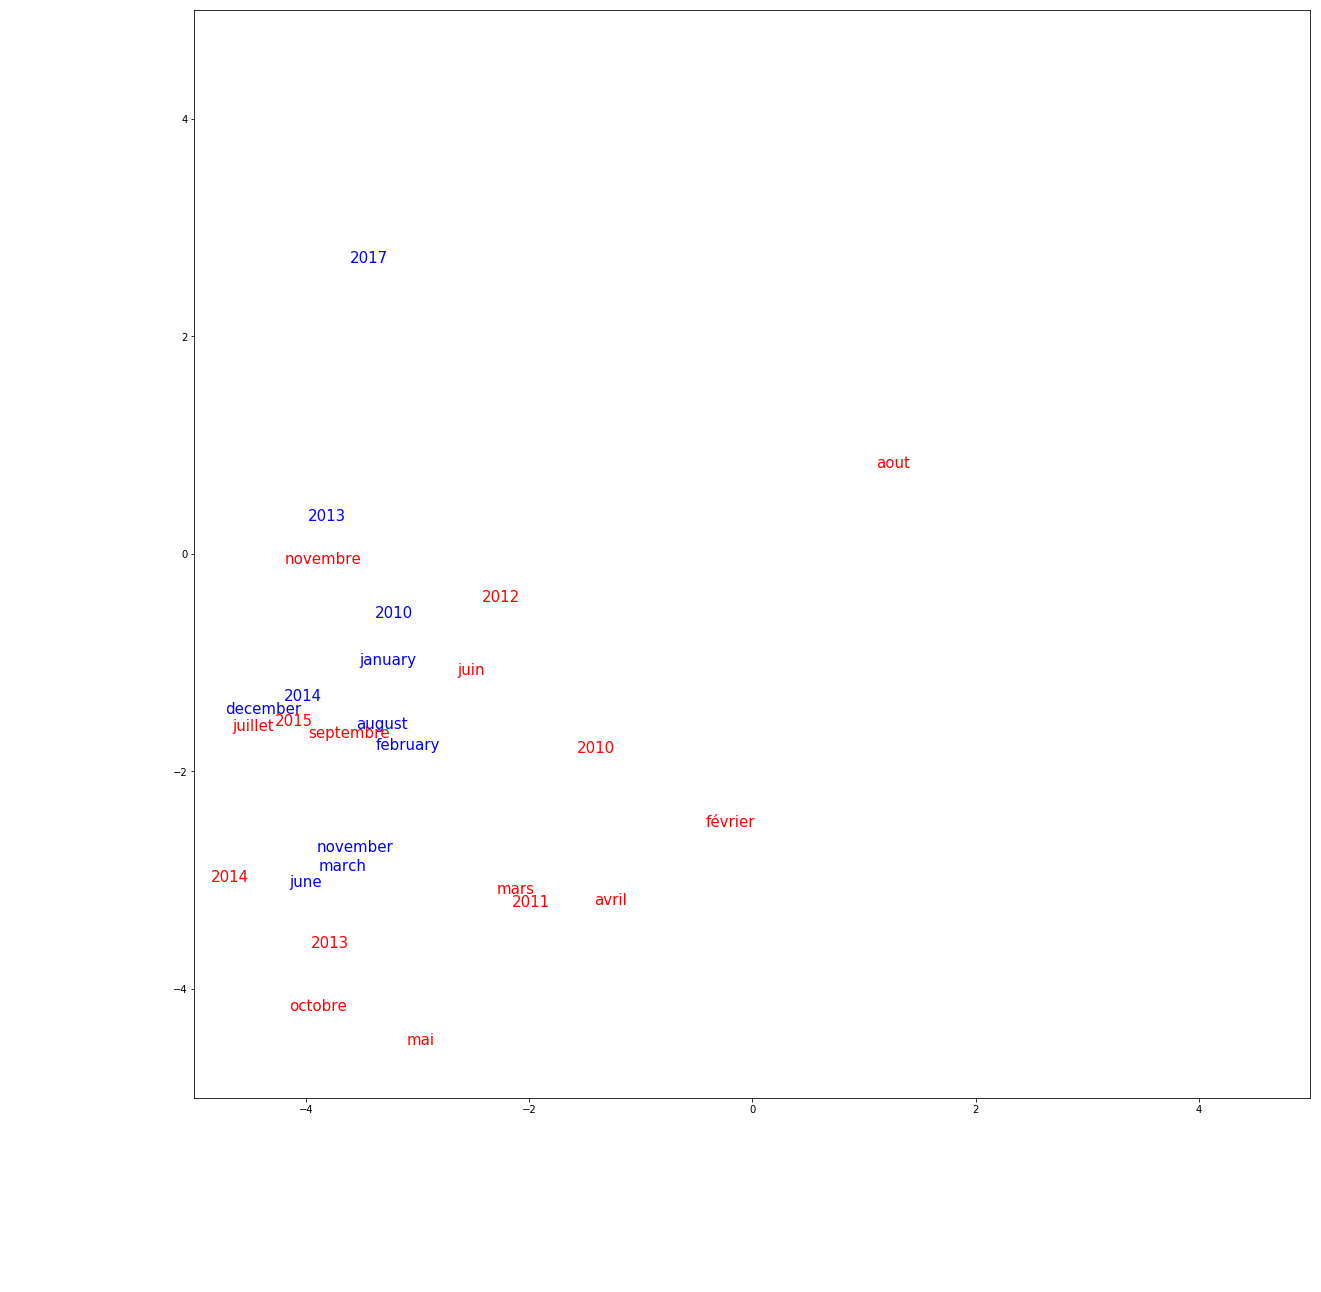

In [99]:
plot_words_pca(pca, vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, hide_original=True)